In [2]:
from enum import Enum
import torch
import logging
import tqdm
import json
import os
import numpy as np
from dataset import RadarDataset
from model import UNet
from torch.utils.data import DataLoader
import torch.nn as nn
from runner import load_checkpoint, save_checkpoint, OptimizerChoice
from train import create_optimizer
from dotenv import load_dotenv
from common import get_scene
from encoder import Grid
import matplotlib.pyplot as plt
from config import label_to_index, CAR, LARGE_VEHICLE, BICYCLE, PEDESTRIAN, STATIC, DONT_CARE, final_labels, N_LABELS, label_to_str
from torchmetrics import ConfusionMatrix

load_dotenv()

%load_ext autoreload
%autoreload 2

In [20]:
n_sequences = np.arange(1, 158)
# n_sequences = np.arange(1, 50)
sequence_strs = [f"sequence_{i}" for i in n_sequences]

stats = {
    "sequence": [],
    "n_frames": [],
    "n_car": [],
    "n_static": [],
    "n_pedestrian": [],
    "n_bicycle": [],
    "n_large_vehicle": [],
    "rcs": [],
    "vr_compensated": [],
    # "rcs": {
    #     "min": 100,
    #     "max": -100
    # },
    # "vr_compensated": {
    #     "min": 100,
    #     "max": -100
    # }
}
for seq in tqdm.tqdm(sequence_strs):
    scene_fn = os.path.join(os.getenv("DATA_LOCATION"), seq, "scenes.json")
    detections = get_scene(scene_fn)
    stats["sequence"].append(seq)
    stats["n_frames"].append(detections['timestamp'].nunique())
    stats["n_car"].append(detections[detections['label_id'] == CAR].shape[0])
    stats["n_static"].append(detections[detections['label_id'] == STATIC].shape[0])
    stats["n_pedestrian"].append(detections[detections['label_id'] == PEDESTRIAN].shape[0])
    stats["n_bicycle"].append(detections[detections['label_id'] == BICYCLE].shape[0])
    stats["n_large_vehicle"].append(detections[detections['label_id'] == LARGE_VEHICLE].shape[0])
    # stats["rcs"] += detections['rcs'].tolist()
    # stats["vr_compensated"] += detections['vr_compensated'].tolist()
    # stats["rcs"]["min"] = min(stats["rcs"]["min"], detections['rcs'].min())
    # stats["rcs"]["max"] = max(stats["rcs"]["max"], detections['rcs'].max())
    # stats["vr_compensated"]["min"] = min(stats["vr_compensated"]["min"], detections['vr_compensated'].min())
    # stats["vr_compensated"]["max"] = max(stats["vr_compensated"]["max"], detections['vr_compensated'].max())


100%|██████████| 157/157 [00:44<00:00,  3.49it/s]


Text(0, 0.5, 'Frequency')

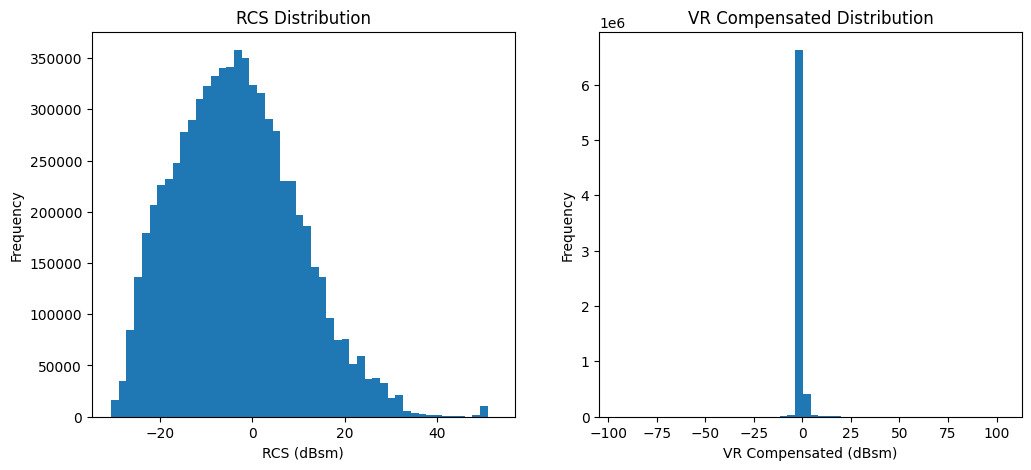

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(stats["rcs"], bins=50)
ax[0].set_title("RCS Distribution")
ax[0].set_xlabel("RCS (dBsm)")
ax[0].set_ylabel("Frequency")
ax[1].hist(stats["vr_compensated"], bins=50)
ax[1].set_title("VR Compensated Distribution")
ax[1].set_xlabel("VR Compensated (dBsm)")
ax[1].set_ylabel("Frequency")
fig.savefig("detection_stats.png")

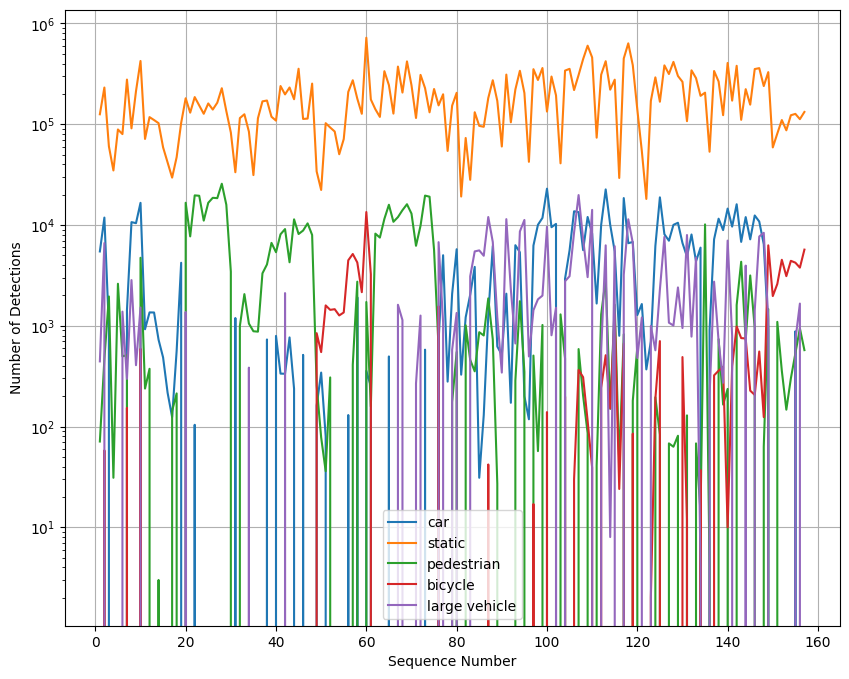

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_sequences, stats['n_car'], label='car')
ax.plot(n_sequences, stats['n_static'], label='static')
ax.plot(n_sequences, stats['n_pedestrian'], label='pedestrian')
ax.plot(n_sequences, stats['n_bicycle'], label='bicycle')
ax.plot(n_sequences, stats['n_large_vehicle'], label='large vehicle')
ax.grid(True)
ax.set_xlabel('Sequence Number')
ax.set_ylabel('Number of Detections')
ax.set_yscale('log')
ax.legend()
plt.show()

In [27]:
train_seq = [
    8,
    10,
    77,
    91,
    98,
    100,
    102,
    105,
    106,
    107,
    131,
    132,
    134,
    137,
    139,
    141,
    142,
    143,
    144,
    146,
    147,
    148,
]
val_seq = [2, 9, 101, 108]
car_static_ratio = np.array(stats['n_car']) / (np.array(stats['n_static']) + 1e-6)
pedestrian_static_ratio = np.array(stats['n_pedestrian']) / (np.array(stats['n_static']) + 1e-6)
bicycle_static_ratio = np.array(stats['n_bicycle']) / (np.array(stats['n_static']) + 1e-6)
lv_static_ratio = np.array(stats['n_large_vehicle']) / (np.array(stats['n_static']) + 1e-6)
np.argsort(-lv_static_ratio)

for n in train_seq:
    if n in val_seq:
        print(f"Sequence {n} is in both training and validation set!")
n_train_frames = sum([stats['n_frames'][i - 1] for i in train_seq])
n_val_frames = sum([stats['n_frames'][i - 1] for i in val_seq])
print(f"Number of training frames: {n_train_frames}")
print(f"Number of validation frames: {n_val_frames}")

Number of training frames: 34763
Number of validation frames: 6887


In [28]:
n_car = 0
n_static = 0
n_pedestrian = 0
n_bicycle = 0
n_large_vehicle = 0
for seq in train_seq:
    idx = stats["sequence"].index(f"sequence_{seq}")
    n_car += stats["n_car"][idx]
    n_static += stats["n_static"][idx]
    n_pedestrian += stats["n_pedestrian"][idx]
    n_bicycle += stats["n_bicycle"][idx]
    n_large_vehicle += stats["n_large_vehicle"][idx]
print("Training set class distribution:")
print(f"Car: {n_car}")
print(f"Static: {n_static}")
print(f"Pedestrian: {n_pedestrian}")
print(f"Bicycle: {n_bicycle}")
print(f"Large Vehicle: {n_large_vehicle}")

all_to_static_ratio = (n_car + n_pedestrian + n_bicycle + n_large_vehicle) / n_static
print(f"All to Static Ratio: {all_to_static_ratio:.3f}")

Training set class distribution:
Car: 219404
Static: 5445101
Pedestrian: 13339
Bicycle: 5654
Large Vehicle: 95113
All to Static Ratio: 0.061


In [31]:
from os import listdir


data_folder = "data/validation/input/"
gt_folder = "data/validation/gt/"
img_name_lists = listdir(data_folder)
gt_name_lists = listdir(gt_folder)
for img, gt in zip(img_name_lists, gt_name_lists):
    assert img == gt, f"Image and GT file names do not match: {img} != {gt}"